In [ ]:
import random
import numpy as np
import torch 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, WeightedRandomSampler
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
#drive.mount('content/drive/My_Drive/Colab_Notebook')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/dataverse_files'

/content/drive/My Drive/Colab Notebooks/dataverse_files


In [ ]:
!ls

HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata  Train.csv


In [ ]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/dataverse_files'

In [ ]:
data_dir = '.'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))


In [ ]:
len(all_image_path)

10015

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

 Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [ ]:
#### the function bellow normalize the images -> for all datset BUT I DESIDED TO NOT USE IT 

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
#norm_mean,norm_std = compute_img_mean_std(all_image_path)

 91%|█████████▏| 9161/10015 [1:00:39<17:13,  1.21s/it]

In [ ]:
#norm_mean,norm_std

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,./HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [ ]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 12)

In [ ]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 12)

In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [ ]:
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [ ]:
df_train['cell_type_idx'].value_counts()


4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [ ]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

## Analysis of the different model with the oversampling technique 

the main dataset whihch I will modify is df_train for training purpose 

### balancing via oversampling 

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/dataverse_files


In [ ]:
######## I am going to save the df_train JIC for the further use -> in case I am not be able to finish everything in one day 
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/dataverse_files/Train.csv')

In [ ]:
#df_train = pd.read_csv('Train.csv')

In [ ]:
df_trainOS = df_train.copy()

In [ ]:
df_trainOS['cell_type'].value_counts()

Melanocytic nevi                  5822
Melanoma                          1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [ ]:
data_aug_rate = [15,10,5,50,0,5,40]
for i in range(7):
    if data_aug_rate[i]:
        df_trainOS=df_trainOS.append([df_trainOS.loc[df_trainOS['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_trainOS['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
Melanoma                          5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [ ]:

df_trainOS = df_trainOS.reset_index()
df_val = df_val.reset_index()


### Model building 

In [ ]:
### using all pretrained model 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)

        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output, whihc I turned off 
        """
        input_size = 299
        model_ft = models.inception_v3(pretrained=use_pretrained,  aux_logits =False )

        #set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        #num_ftrs = model_ft.AuxLogits.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == "mobilenet":
      """mobilenet_v3_small"""
      model_ft = models.mobilenet_v3_small(pretrained=True)
      set_parameter_requires_grad(model_ft, feature_extract)
      model_ft.classifier[3].out_features = 7
#      num_ftrs = model_ft.fc.in_features
 #     model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)
      input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

### starting with resnet 

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

### Dataset 

In [ ]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
input_size =224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_trainOS, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

### training Resnet

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg


In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
##### training resnet 


epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.51131], [train acc 0.40969]
[epoch 1], [iter 200 / 1124], [train loss 1.40152], [train acc 0.45984]
[epoch 1], [iter 300 / 1124], [train loss 1.33854], [train acc 0.49375]
[epoch 1], [iter 400 / 1124], [train loss 1.26995], [train acc 0.52336]
[epoch 1], [iter 500 / 1124], [train loss 1.21899], [train acc 0.54619]
[epoch 1], [iter 600 / 1124], [train loss 1.17189], [train acc 0.56500]
[epoch 1], [iter 700 / 1124], [train loss 1.13955], [train acc 0.57804]
[epoch 1], [iter 800 / 1124], [train loss 1.11201], [train acc 0.58820]
[epoch 1], [iter 900 / 1124], [train loss 1.08276], [train acc 0.59906]
[epoch 1], [iter 1000 / 1124], [train loss 1.05662], [train acc 0.60875]
[epoch 1], [iter 1100 / 1124], [train loss 1.03439], [train acc 0.61693]
------------------------------------------------------------
[epoch 1], [val loss 0.55623], [val acc 0.78613]
------------------------------------------------------------
***********************************

### evaluation Resnet

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

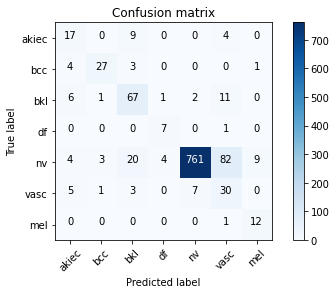

In [ ]:
### evaluation resnet 

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

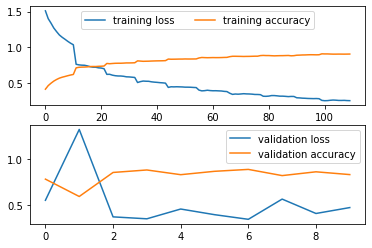

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.47      0.57      0.52        30
         bcc       0.84      0.77      0.81        35
         bkl       0.66      0.76      0.71        88
          df       0.58      0.88      0.70         8
          nv       0.99      0.86      0.92       883
        vasc       0.23      0.65      0.34        46
         mel       0.55      0.92      0.69        13

    accuracy                           0.83      1103
   macro avg       0.62      0.77      0.67      1103
weighted avg       0.90      0.83      0.86      1103



In [ ]:
!pip install scikit-plot

### Vgg model training 

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

In [ ]:
##### training Vgg

optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.78325], [train acc 0.28906]
[epoch 1], [iter 200 / 1124], [train loss 1.61910], [train acc 0.35266]
[epoch 1], [iter 300 / 1124], [train loss 1.56319], [train acc 0.37792]
[epoch 1], [iter 400 / 1124], [train loss 1.49699], [train acc 0.40844]
[epoch 1], [iter 500 / 1124], [train loss 1.44888], [train acc 0.43250]
[epoch 1], [iter 600 / 1124], [train loss 1.40233], [train acc 0.45448]
[epoch 1], [iter 700 / 1124], [train loss 1.36469], [train acc 0.47196]
[epoch 1], [iter 800 / 1124], [train loss 1.32636], [train acc 0.48844]
[epoch 1], [iter 900 / 1124], [train loss 1.28934], [train acc 0.50271]
[epoch 1], [iter 1000 / 1124], [train loss 1.25683], [train acc 0.51734]
[epoch 1], [iter 1100 / 1124], [train loss 1.22613], [train acc 0.53088]
------------------------------------------------------------
[epoch 1], [val loss 0.41205], [val acc 0.84339]
------------------------------------------------------------
***********************************

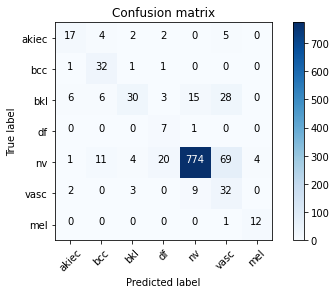

In [ ]:
### evaluation Vgg

modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

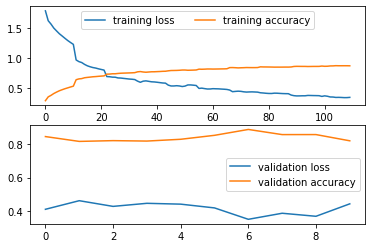

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.63      0.57      0.60        30
         bcc       0.60      0.91      0.73        35
         bkl       0.75      0.34      0.47        88
          df       0.21      0.88      0.34         8
          nv       0.97      0.88      0.92       883
        vasc       0.24      0.70      0.35        46
         mel       0.75      0.92      0.83        13

    accuracy                           0.82      1103
   macro avg       0.59      0.74      0.61      1103
weighted avg       0.89      0.82      0.84      1103



### Training Densnet 

In [ ]:
############ model densnet
# resnet,vgg,densenet,inception,mobilenet
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.28673], [train acc 0.51406]
[epoch 1], [iter 200 / 1124], [train loss 1.15052], [train acc 0.57016]
[epoch 1], [iter 300 / 1124], [train loss 1.08668], [train acc 0.59583]
[epoch 1], [iter 400 / 1124], [train loss 1.02628], [train acc 0.61789]
[epoch 1], [iter 500 / 1124], [train loss 0.98778], [train acc 0.63150]
[epoch 1], [iter 600 / 1124], [train loss 0.95212], [train acc 0.64510]
[epoch 1], [iter 700 / 1124], [train loss 0.92563], [train acc 0.65531]
[epoch 1], [iter 800 / 1124], [train loss 0.89985], [train acc 0.66398]
[epoch 1], [iter 900 / 1124], [train loss 0.87676], [train acc 0.67312]
[epoch 1], [iter 1000 / 1124], [train loss 0.85545], [train acc 0.68078]
[epoch 1], [iter 1100 / 1124], [train loss 0.83918], [train acc 0.68699]
------------------------------------------------------------
[epoch 1], [val loss 0.47650], [val acc 0.83905]
------------------------------------------------------------
***********************************

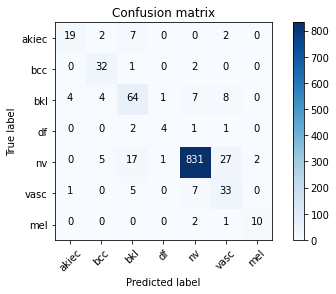

In [ ]:
### evaluation Densnet

modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

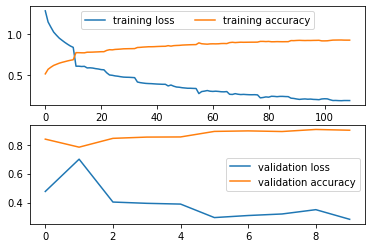

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.79      0.63      0.70        30
         bcc       0.74      0.91      0.82        35
         bkl       0.67      0.73      0.70        88
          df       0.67      0.50      0.57         8
          nv       0.98      0.94      0.96       883
        vasc       0.46      0.72      0.56        46
         mel       0.83      0.77      0.80        13

    accuracy                           0.90      1103
   macro avg       0.73      0.74      0.73      1103
weighted avg       0.91      0.90      0.91      1103



### Training inception

In [ ]:
######## model inception


train_transformI = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transformI = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setI = HAM10000(df_trainOS, transform=train_transformI)
train_loaderI = DataLoader(training_setI, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_setI = HAM10000(df_val, transform=val_transformI)
val_loaderI = DataLoader(validation_setI, batch_size=32, shuffle=False, num_workers=4)

###### training inception 


In [ ]:
modelI

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderI, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.34447], [train acc 0.49875]
[epoch 1], [iter 200 / 1124], [train loss 1.20052], [train acc 0.56406]
[epoch 1], [iter 300 / 1124], [train loss 1.11813], [train acc 0.59719]
[epoch 1], [iter 400 / 1124], [train loss 1.05184], [train acc 0.62117]
[epoch 1], [iter 500 / 1124], [train loss 1.00918], [train acc 0.63744]
[epoch 1], [iter 600 / 1124], [train loss 0.96734], [train acc 0.65125]
[epoch 1], [iter 700 / 1124], [train loss 0.93785], [train acc 0.66094]
[epoch 1], [iter 800 / 1124], [train loss 0.91036], [train acc 0.66934]
[epoch 1], [iter 900 / 1124], [train loss 0.88679], [train acc 0.67826]
[epoch 1], [iter 1000 / 1124], [train loss 0.86189], [train acc 0.68678]
[epoch 1], [iter 1100 / 1124], [train loss 0.83800], [train acc 0.69511]
------------------------------------------------------------
[epoch 1], [val loss 0.30248], [val acc 0.88292]
------------------------------------------------------------
***********************************

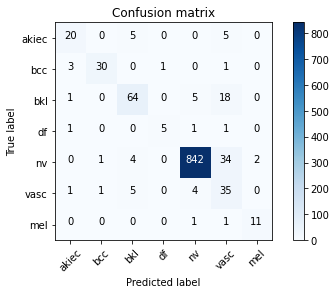

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

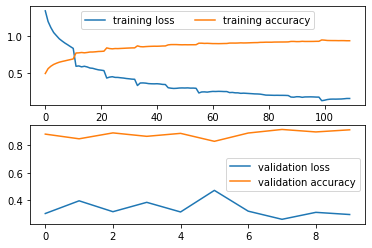

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.77      0.67      0.71        30
         bcc       0.94      0.86      0.90        35
         bkl       0.82      0.73      0.77        88
          df       0.83      0.62      0.71         8
          nv       0.99      0.95      0.97       883
        vasc       0.37      0.76      0.50        46
         mel       0.85      0.85      0.85        13

    accuracy                           0.91      1103
   macro avg       0.79      0.78      0.77      1103
weighted avg       0.94      0.91      0.92      1103



### Training mobilenet 


In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [iter 100 / 1124], [train loss 1.56626], [train acc 0.51125]
[epoch 1], [iter 200 / 1124], [train loss 1.25718], [train acc 0.58250]
[epoch 1], [iter 300 / 1124], [train loss 1.11564], [train acc 0.61865]
[epoch 1], [iter 400 / 1124], [train loss 1.02706], [train acc 0.64609]
[epoch 1], [iter 500 / 1124], [train loss 0.95335], [train acc 0.66656]
[epoch 1], [iter 600 / 1124], [train loss 0.89874], [train acc 0.68307]
[epoch 1], [iter 700 / 1124], [train loss 0.85319], [train acc 0.69723]
[epoch 1], [iter 800 / 1124], [train loss 0.81778], [train acc 0.70848]
[epoch 1], [iter 900 / 1124], [train loss 0.79049], [train acc 0.71764]
[epoch 1], [iter 1000 / 1124], [train loss 0.76318], [train acc 0.72653]
[epoch 1], [iter 1100 / 1124], [train loss 0.73643], [train acc 0.73545]
------------------------------------------------------------
[epoch 1], [val loss 0.35598], [val acc 0.86315]
------------------------------------------------------------
***********************************

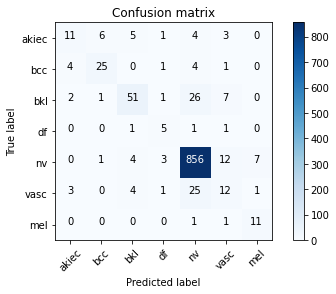

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

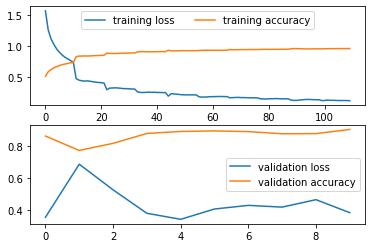

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.55      0.37      0.44        30
         bcc       0.76      0.71      0.74        35
         bkl       0.78      0.58      0.67        88
          df       0.42      0.62      0.50         8
          nv       0.93      0.97      0.95       883
        vasc       0.32      0.26      0.29        46
         mel       0.58      0.85      0.69        13

    accuracy                           0.88      1103
   macro avg       0.62      0.62      0.61      1103
weighted avg       0.87      0.88      0.87      1103



### balancing via balanced sampling  

In [ ]:
df_trainBalanced = df_original[df_original['train_or_val'] == 'train']
print(len(df_trainBalanced))

8912


In [ ]:
df_val = df_val.reset_index()

In [ ]:
df_trainBalanced = df_trainBalanced.reset_index()
#
df_trainBalanced.head()

In [ ]:
class_sample_count = np.array(
    [len(np.where(df_trainBalanced.cell_type == t)[0]) for t in np.unique(df_trainBalanced.cell_type)])

weight = 1. / class_sample_count
weight




array([0.003367  , 0.00208768, 0.00098912, 0.00934579, 0.00017176,
       0.00093721, 0.00775194])

In [ ]:

samples_weight=np.array([weight[t] for t in df_trainBalanced.cell_type_idx])
print(samples_weight)
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

[0.00098912 0.00098912 0.00098912 ... 0.003367   0.003367   0.00093721]


In [ ]:
samples_weigth *10

tensor([0.0099, 0.0099, 0.0099,  ..., 0.0337, 0.0337, 0.0094],
       dtype=torch.float64)

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setBalanced = HAM10000(df_trainBalanced , transform=train_transform)
train_loaderBalanced = DataLoader(training_setBalanced,batch_size=32,  sampler=sampler, num_workers=4)
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
sampler.num_samples

8912

In [ ]:
#### repetining the resnet50 model with the randomSAMPLIER 

### Resnet via Balancedsampling

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [ ]:
train_loaderBalanced.batch_size

32

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 1.58519], [train acc 0.38406]
[epoch 1], [iter 200 / 279], [train loss 1.45861], [train acc 0.43875]
------------------------------------------------------------
[epoch 1], [val loss 0.48327], [val acc 0.83000]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.48327], [val acc 0.83000]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 1.15577], [train acc 0.58313]
[epoch 2], [iter 200 / 279], [train loss 1.10723], [train acc 0.59766]
------------------------------------------------------------
[epoch 2], [val loss 1.04531], [val acc 0.66970]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.97123], [train acc 0.64656]
[epoch 3], [iter 200 / 279], [train loss 0.94851], [train acc 0.64875]
------------------------------------------------------------
[

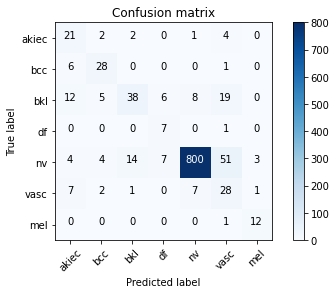

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

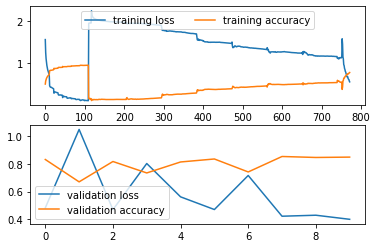

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.55      0.37      0.44        30
         bcc       0.76      0.71      0.74        35
         bkl       0.78      0.58      0.67        88
          df       0.42      0.62      0.50         8
          nv       0.93      0.97      0.95       883
        vasc       0.32      0.26      0.29        46
         mel       0.58      0.85      0.69        13

    accuracy                           0.88      1103
   macro avg       0.62      0.62      0.61      1103
weighted avg       0.87      0.88      0.87      1103



### VGG

In [ ]:
############ next model is the vgg
# resnet,vgg,densenet,inception,mobilenet
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)


epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelVgg, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 1.53209], [train acc 0.40281]
[epoch 1], [iter 200 / 279], [train loss 1.39430], [train acc 0.46563]
------------------------------------------------------------
[epoch 1], [val loss 0.91521], [val acc 0.65119]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.91521], [val acc 0.65119]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 1.05971], [train acc 0.60813]
[epoch 2], [iter 200 / 279], [train loss 1.03147], [train acc 0.61844]
------------------------------------------------------------
[epoch 2], [val loss 0.48666], [val acc 0.80232]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.48666], [val acc 0.80232]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

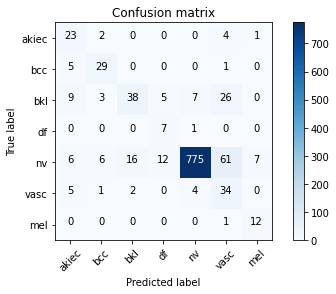

In [ ]:
modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

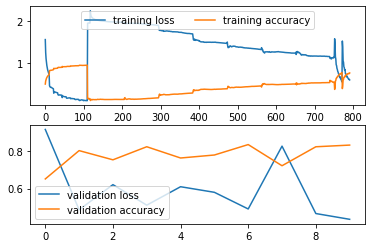

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.48      0.77      0.59        30
         bcc       0.71      0.83      0.76        35
         bkl       0.68      0.43      0.53        88
          df       0.29      0.88      0.44         8
          nv       0.98      0.88      0.93       883
        vasc       0.27      0.74      0.39        46
         mel       0.60      0.92      0.73        13

    accuracy                           0.83      1103
   macro avg       0.57      0.78      0.62      1103
weighted avg       0.90      0.83      0.85      1103



### DEnsnet

In [ ]:
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 279], [train loss 1.28401], [train acc 0.53250]
[epoch 1], [iter 200 / 279], [train loss 1.15460], [train acc 0.58047]
------------------------------------------------------------
[epoch 1], [val loss 0.78268], [val acc 0.72274]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.78268], [val acc 0.72274]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.86050], [train acc 0.68188]
[epoch 2], [iter 200 / 279], [train loss 0.82868], [train acc 0.69781]
------------------------------------------------------------
[epoch 2], [val loss 0.82391], [val acc 0.71714]
------------------------------------------------------------
[epoch 3], [iter 100 / 279], [train loss 0.70448], [train acc 0.74250]
[epoch 3], [iter 200 / 279], [train loss 0.72192], [train acc 0.73578]
------------------------------------------------------------
[

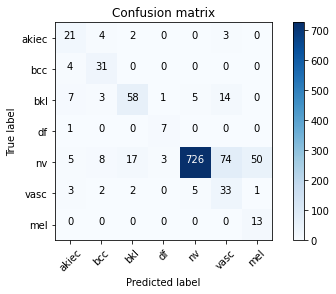

In [ ]:
modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

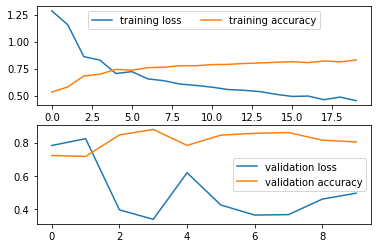

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.51      0.70      0.59        30
         bcc       0.65      0.89      0.75        35
         bkl       0.73      0.66      0.69        88
          df       0.64      0.88      0.74         8
          nv       0.99      0.82      0.90       883
        vasc       0.27      0.72      0.39        46
         mel       0.20      1.00      0.34        13

    accuracy                           0.81      1103
   macro avg       0.57      0.81      0.63      1103
weighted avg       0.90      0.81      0.84      1103



### Inception

In [ ]:

model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loaderI, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 279], [train loss 1.39106], [train acc 0.50469]
[epoch 1], [iter 200 / 279], [train loss 1.25913], [train acc 0.55484]
------------------------------------------------------------
[epoch 1], [val loss 0.70659], [val acc 0.77363]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.70659], [val acc 0.77363]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.89876], [train acc 0.67625]
[epoch 2], [iter 200 / 279], [train loss 0.87165], [train acc 0.67922]
------------------------------------------------------------
[epoch 2], [val loss 0.42925], [val acc 0.84964]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.42925], [val acc 0.84964]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

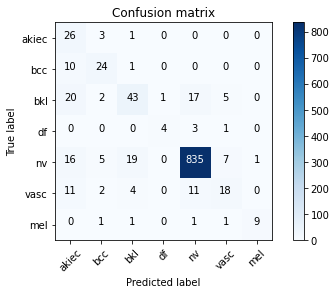

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loaderI):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

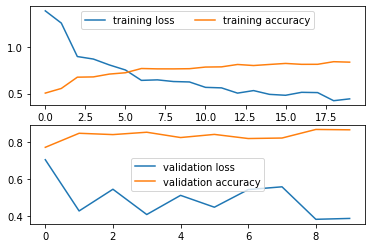

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.31      0.87      0.46        30
         bcc       0.65      0.69      0.67        35
         bkl       0.62      0.49      0.55        88
          df       0.80      0.50      0.62         8
          nv       0.96      0.95      0.95       883
        vasc       0.56      0.39      0.46        46
         mel       0.90      0.69      0.78        13

    accuracy                           0.87      1103
   macro avg       0.69      0.65      0.64      1103
weighted avg       0.89      0.87      0.87      1103



### Mobilenet

In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loaderBalanced, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')


[epoch 1], [iter 100 / 279], [train loss 1.57071], [train acc 0.51000]
[epoch 1], [iter 200 / 279], [train loss 1.25969], [train acc 0.58344]
------------------------------------------------------------
[epoch 1], [val loss 0.49323], [val acc 0.82565]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.49323], [val acc 0.82565]
*****************************************************
[epoch 2], [iter 100 / 279], [train loss 0.76820], [train acc 0.71906]
[epoch 2], [iter 200 / 279], [train loss 0.71406], [train acc 0.73531]
------------------------------------------------------------
[epoch 2], [val loss 0.42456], [val acc 0.84250]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.42456], [val acc 0.84250]
*****************************************************
[epoch 3], [iter 100 / 279], [trai

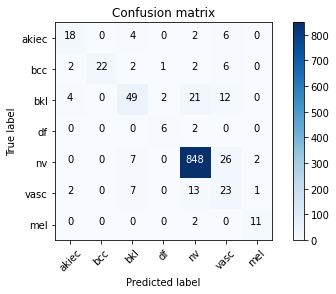

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

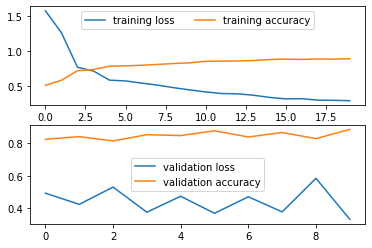

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.69      0.60      0.64        30
         bcc       1.00      0.63      0.77        35
         bkl       0.71      0.56      0.62        88
          df       0.67      0.75      0.71         8
          nv       0.95      0.96      0.96       883
        vasc       0.32      0.50      0.39        46
         mel       0.79      0.85      0.81        13

    accuracy                           0.89      1103
   macro avg       0.73      0.69      0.70      1103
weighted avg       0.90      0.89      0.89      1103



### balancing via loss function 

In [ ]:
import math 
num_classes =7 
beta = torch.log(num_classes -1)

In [ ]:
labels = sorted(df_train.cell_type_idx.unique())
classWeight = []
max =0 
for i in labels:
  classLen = len(df_train.loc[df_train.cell_type_idx==i])
  classWeight.append(classLen)
  if classLen >max:
    max =classLen 
  
classW =[(max/x) for x in classWeight]
classW

[19.602693602693602,
 12.154488517745303,
 5.758654797230465,
 54.41121495327103,
 1.0,
 5.456419868791003,
 45.13178294573643]

In [ ]:
classW= torch.tensor(classW, dtype=torch.float).to(device)

In [ ]:

criterion = nn.CrossEntropyLoss(weight=classW).to(device)

In [ ]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()


# Define the training set using the table train_df and using our defined transitions (train_transform)
training_setFL = HAM10000(df_train, transform=train_transform)
train_loaderFL = DataLoader(training_setFL,batch_size=32,   num_workers=1)
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=1)

### Resnet 

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
model_name = 'resnet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.20528], [train acc 0.26375]
[epoch 1], [iter 200 / 1124], [train loss 1.08923], [train acc 0.29844]
[epoch 1], [iter 300 / 1124], [train loss 1.01532], [train acc 0.32344]
[epoch 1], [iter 400 / 1124], [train loss 0.97206], [train acc 0.34117]
[epoch 1], [iter 500 / 1124], [train loss 0.93397], [train acc 0.35875]
[epoch 1], [iter 600 / 1124], [train loss 0.90317], [train acc 0.37083]
[epoch 1], [iter 700 / 1124], [train loss 0.86769], [train acc 0.38366]
[epoch 1], [iter 800 / 1124], [train loss 0.83804], [train acc 0.39766]
[epoch 1], [iter 900 / 1124], [train loss 0.81224], [train acc 0.41066]
[epoch 1], [iter 1000 / 1124], [train loss 0.78602], [train acc 0.42484]
[epoch 1], [iter 1100 / 1124], [train loss 0.76470], [train acc 0.43545]
------------------------------------------------------------
[epoch 1], [val loss 1.36633], [val acc 0.43833]
------------------------------------------------------------
***********************************

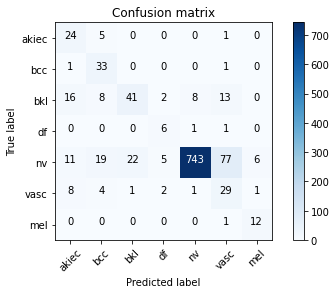

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

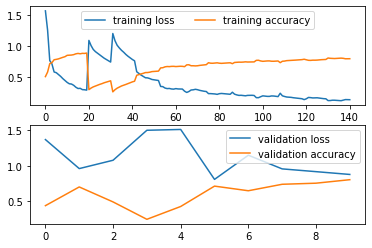

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.40      0.80      0.53        30
         bcc       0.48      0.94      0.63        35
         bkl       0.64      0.47      0.54        88
          df       0.40      0.75      0.52         8
          nv       0.99      0.84      0.91       883
        vasc       0.24      0.63      0.34        46
         mel       0.63      0.92      0.75        13

    accuracy                           0.81      1103
   macro avg       0.54      0.76      0.60      1103
weighted avg       0.89      0.81      0.83      1103



### VGG

In [ ]:
# resnet,vgg,densenet,inception,mobilenet
num_classes =7
feature_extract = False
model_nameVgg = 'vgg'
# Initialize the model for this run
model_ft2, input_size2 = initialize_model(model_nameVgg, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelVgg = model_ft2.to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
Newloss = FocalLoss(weight=classW)

In [ ]:
total_loss_train, total_acc_train = [],[]
def trainFL(train_loader, model,  optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = Newloss(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg


In [ ]:
optimizer = optim.Adam(modelVgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=classW).to(device)

epoch = 10
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelVgg,criterion,  optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelVgg, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1439], [train loss 1.61938], [train acc 0.14640]
[epoch 1], [iter 200 / 1439], [train loss 1.58769], [train acc 0.15020]
[epoch 1], [iter 300 / 1439], [train loss 1.56642], [train acc 0.15600]
[epoch 1], [iter 400 / 1439], [train loss 1.53667], [train acc 0.16710]
[epoch 1], [iter 500 / 1439], [train loss 1.46548], [train acc 0.18824]
[epoch 1], [iter 600 / 1439], [train loss 1.40329], [train acc 0.20327]
[epoch 1], [iter 700 / 1439], [train loss 1.35701], [train acc 0.21497]
[epoch 1], [iter 800 / 1439], [train loss 1.31486], [train acc 0.22560]
[epoch 1], [iter 900 / 1439], [train loss 1.27931], [train acc 0.23627]
[epoch 1], [iter 1000 / 1439], [train loss 1.25611], [train acc 0.24360]
[epoch 1], [iter 1100 / 1439], [train loss 1.22409], [train acc 0.25196]
[epoch 1], [iter 1200 / 1439], [train loss 1.19943], [train acc 0.26083]
[epoch 1], [iter 1300 / 1439], [train loss 1.17932], [train acc 0.26643]
[epoch 1], [iter 1400 / 1439], [train loss 1.15853], [train 

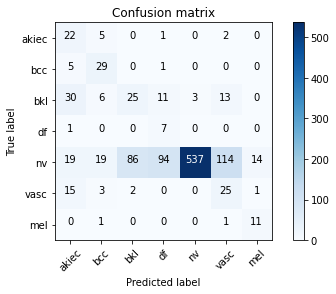

In [ ]:
modelVgg.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelVgg(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

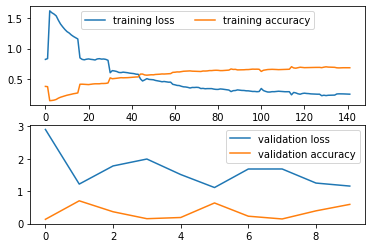

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.24      0.73      0.36        30
         bcc       0.46      0.83      0.59        35
         bkl       0.22      0.28      0.25        88
          df       0.06      0.88      0.11         8
          nv       0.99      0.61      0.75       883
        vasc       0.16      0.54      0.25        46
         mel       0.42      0.85      0.56        13

    accuracy                           0.59      1103
   macro avg       0.37      0.67      0.41      1103
weighted avg       0.85      0.59      0.67      1103



### DEnsenet

In [ ]:
model_nameDen = 'densenet'
# Initialize the model for this run
model_ft3, input_size3 = initialize_model(model_nameDen, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelDen = model_ft3.to(device)


###### training densnet 

optimizer = optim.Adam(modelDen.parameters(), lr=1e-3)
total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelDen, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelDen, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 1439], [train loss 1.00247], [train acc 0.35360]
[epoch 1], [iter 200 / 1439], [train loss 0.93158], [train acc 0.37940]
[epoch 1], [iter 300 / 1439], [train loss 0.85669], [train acc 0.40747]
[epoch 1], [iter 400 / 1439], [train loss 0.81730], [train acc 0.42360]
[epoch 1], [iter 500 / 1439], [train loss 0.77407], [train acc 0.44248]
[epoch 1], [iter 600 / 1439], [train loss 0.74722], [train acc 0.45293]
[epoch 1], [iter 700 / 1439], [train loss 0.70575], [train acc 0.47223]
[epoch 1], [iter 800 / 1439], [train loss 0.68433], [train acc 0.48365]
[epoch 1], [iter 900 / 1439], [train loss 0.66675], [train acc 0.49222]
[epoch 1], [iter 1000 / 1439], [train loss 0.64690], [train acc 0.50300]
[epoch 1], [iter 1100 / 1439], [train loss 0.62734], [train acc 0.51120]
[epoch 1], [iter 1200 / 1439], [train loss 0.60830], [train acc 0.52117]
[epoch 1], [iter 1300 / 1439], [train loss 0.59253], [train acc 0.52997]
[epoch 1], [iter 1400 / 1439], [train loss 0.57767], [train 

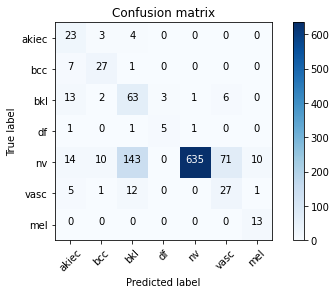

In [ ]:
modelDen.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelDen(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

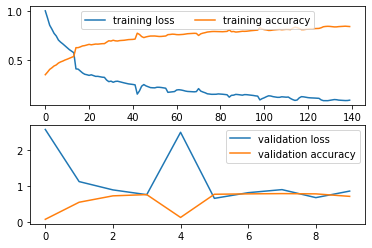

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.37      0.77      0.49        30
         bcc       0.63      0.77      0.69        35
         bkl       0.28      0.72      0.40        88
          df       0.62      0.62      0.62         8
          nv       1.00      0.72      0.84       883
        vasc       0.26      0.59      0.36        46
         mel       0.54      1.00      0.70        13

    accuracy                           0.72      1103
   macro avg       0.53      0.74      0.59      1103
weighted avg       0.87      0.72      0.76      1103



### Intercept

In [ ]:
model_nameI = 'inception'
# Initialize the model for this run
num_classes = 7
feature_extract = False
model_ft, input_size = initialize_model(model_nameI,num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelI = model_ft.to(device)


###### training densnet 

optimizer = optim.Adam(modelI.parameters(), lr=1e-3)


total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelI, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelI, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

[epoch 1], [iter 100 / 1439], [train loss 1.11988], [train acc 0.29240]
[epoch 1], [iter 200 / 1439], [train loss 0.97524], [train acc 0.33980]
[epoch 1], [iter 300 / 1439], [train loss 0.89617], [train acc 0.37267]
[epoch 1], [iter 400 / 1439], [train loss 0.84412], [train acc 0.39310]
[epoch 1], [iter 500 / 1439], [train loss 0.80852], [train acc 0.40944]
[epoch 1], [iter 600 / 1439], [train loss 0.77359], [train acc 0.42653]
[epoch 1], [iter 700 / 1439], [train loss 0.74683], [train acc 0.43954]
[epoch 1], [iter 800 / 1439], [train loss 0.71669], [train acc 0.45250]
[epoch 1], [iter 900 / 1439], [train loss 0.69440], [train acc 0.45991]
[epoch 1], [iter 1000 / 1439], [train loss 0.66626], [train acc 0.47172]
[epoch 1], [iter 1100 / 1439], [train loss 0.65183], [train acc 0.47855]
[epoch 1], [iter 1200 / 1439], [train loss 0.63433], [train acc 0.48693]
[epoch 1], [iter 1300 / 1439], [train loss 0.62098], [train acc 0.49400]
[epoch 1], [iter 1400 / 1439], [train loss 0.60491], [train 

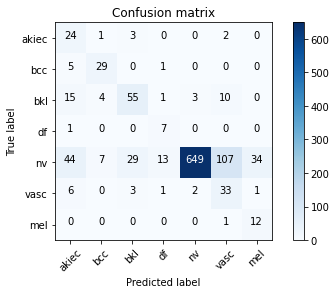

In [ ]:
modelI.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelI(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

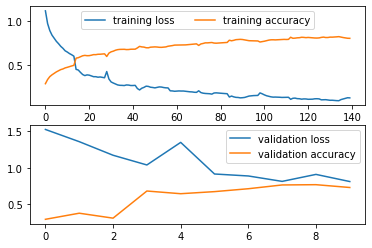

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.25      0.80      0.38        30
         bcc       0.71      0.83      0.76        35
         bkl       0.61      0.62      0.62        88
          df       0.30      0.88      0.45         8
          nv       0.99      0.73      0.84       883
        vasc       0.22      0.72      0.33        46
         mel       0.26      0.92      0.40        13

    accuracy                           0.73      1103
   macro avg       0.48      0.79      0.54      1103
weighted avg       0.89      0.73      0.78      1103



### Mobilenet

In [ ]:
# model mobilenet
model_nameM = 'mobilenet'
# Initialize the model for this run
model_ft5, input_size5 = initialize_model(model_nameM, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
modelM = model_ft5.to(device)


###### training mobilenet

optimizer = optim.Adam(modelM.parameters(), lr=1e-3)


total_loss_train, total_acc_train = [],[]

epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, modelM, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, modelM, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
modelM.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = modelM(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend(loc='upper center', ncol=2)
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()

In [ ]:
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)